In [20]:

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [21]:
!pip3 install sacrebleu

In [22]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

0.4.1
True


In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import operator
from torch.utils.data import Dataset
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from sacrebleu import corpus_bleu, TOKENIZERS, DEFAULT_TOKENIZER
from torch.optim.lr_scheduler import ExponentialLR
from torch.autograd import Variable
import random
from torch.nn import functional

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PAD_token = 0
SOS_token = 1
EOS_token = 2
hidden_size = 1024
dropout_p = 0.1
teacher_forcing_ratio = 1
BATCH_SIZE = 64
MIN_LENGTH = 1
MAX_LENGTH = 55
source_vocab_size = 19000
target_vocab_size = 22000
n_layers = 4
lr_rate_en = 0.0001
lr_rate_de = 0.0005
lr_decay = False
gamma_encoder = 0.9
gamma_decoder = 0.9
n_epochs = 20
plot_every = 100
print_every = 100
evaluate_every = 500
attn_model = 'dot'
Attention = True
search_method = 'greedy'
beam_size = 10
n_best = 5
dynamic_sentence_length = False

In [0]:
def filter_pairs(pairs):
    filtered_pairs = []
    for pair in pairs:
        if len(pair[0].split()) >= MIN_LENGTH and len(pair[0].split()) <= MAX_LENGTH \
            and len(pair[1].split()) >= MIN_LENGTH and len(pair[1].split()) <= MAX_LENGTH:
            filtered_pairs.append(pair)
    return filtered_pairs

In [0]:
def sequence_mask(sequence_length, max_len=None):
    """
    Code paraphrased from 
    https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/masked_cross_entropy.py
    """
    if max_len is None:
        max_len = sequence_length.data.max()
    batch_size = sequence_length.size(0)
    seq_range = torch.arange(0, max_len).long()
    seq_range_expand = seq_range.unsqueeze(0).expand(batch_size, max_len).contiguous()
    seq_range_expand = seq_range_expand.to(device)
    seq_length_expand = (sequence_length.unsqueeze(1)
                         .expand_as(seq_range_expand))
    return seq_range_expand < seq_length_expand



def masked_cross_entropy(logits, target, length):
    length = torch.LongTensor(length).to(device)
    """
    Code paraphrased from 
    https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/masked_cross_entropy.py
    """
    
    """
    Args:
        logits: A Variable containing a FloatTensor of size
            (batch, max_len, num_classes) which contains the
            unnormalized probability for each class.
        target: A Variable containing a LongTensor of size
            (batch, max_len) which contains the index of the true
            class for each corresponding step.
        length: A Variable containing a LongTensor of size (batch,)
            which contains the length of each data in a batch.

    Returns:
        loss: An average loss value masked by the length.
    """

    logits_flat = logits.view(-1, logits.size(-1))
    log_probs_flat = functional.log_softmax(logits_flat, dim=1)
    target_flat = target.view(-1, 1)
    losses_flat = -torch.gather(log_probs_flat, dim=1, index=target_flat)
    losses = losses_flat.view(*target.size())
    mask = sequence_mask(sequence_length=length, max_len=target.size(1))
    losses = losses * mask.float()
    loss = losses.sum() / length.float().sum()
    return loss

## Loading Data

In [28]:
class Lang:
    '''
    Part of the codes are paraphrased from
    https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
    '''
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "<PAD>", 1: "<SOS>", 2:"<EOS>", 3:"<UNK>"}
        self.n_words = 4  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


other_punctuations = string.punctuation.replace('!','').replace('.','').replace('?','').replace(',','').replace('-','')

def normalizeEnString(s):
#     s = unicodeToAscii(s.strip())
    s = s.replace("&apos", "").replace("&quot","")
#    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z,.!?0-9]+", r" ", s)
    s = re.sub( '\s+', ' ', s).strip()
    return s

def normalizeViString(s):
    s = s.replace("&apos", "").replace("&quot","").replace("_","").replace('-','')
    s = re.sub(r'[{}]'.format(other_punctuations), '', s)
    s = re.sub( '\s+', ' ', s).strip()
    return s


print(normalizeEnString("It &apos;s very pretty , and it has rapidly started to overgrow the \
                  once very rich biodiversity of the northwestern Mediterranean ."))
normalizeViString('húng_ta đã đạt được điều này qua công_nghệ đến_mức mili - giây . và điều này cho_phép Peter nhìn_thấy não_bộ anh ấy dưới thời_gian thực khi anh ta ở trong máy_quét .')               

It s very pretty , and it has rapidly started to overgrow the once very rich biodiversity of the northwestern Mediterranean .


'húngta đã đạt được điều này qua côngnghệ đếnmức mili giây . và điều này chophép Peter nhìnthấy nãobộ anh ấy dưới thờigian thực khi anh ta ở trong máyquét .'

In [0]:
# open('/content/drive/My Drive/iwslt-vi-en/{}.tok.vi'.format('train')).read().split('\n')

In [30]:
def readLangs(lang1, lang2, data='train'):
    '''
    Part of the codes are paraphrased from
    https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
    '''
    #data: train/dev/test
    print("Reading lines...")
    # Read the file and split into lines
    zh_lines = open('/content/drive/My Drive/iwslt-vi-en/{}.tok.vi'.format(data)).read().split('\n')
    en_lines = open('/content/drive/My Drive/iwslt-vi-en/{}.tok.en'.format(data)).read().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeViString(element[0]), normalizeEnString(element[1])] for element in zip(zh_lines, en_lines)]

    input_lang = Lang(lang1)
    output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

def prepareData(lang1, lang2):
    input_lang, output_lang, pairs = readLangs(lang1, lang2)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

def build_topwordVocab(lang, vocab_size):
    print("Build vocabulary by top {} frequent word...".format(vocab_size))
    sorted_word2Count = sorted(lang.word2count.items(),
        key=operator.itemgetter(1),
        reverse=True)
    sorted_words = [x[0] for x in sorted_word2Count[:vocab_size]]
    
    lang.word2index = {}

    for ind, word in enumerate(sorted_words):
            lang.word2index[word] = ind + 4
    lang.index2word = {}
    lang.index2word[0] = "<PAD>"
    lang.index2word[1] = "<SOS>"
    lang.index2word[2] = "<EOS>"
    lang.index2word[3] = "<UNK>"

    for ind, word in enumerate(sorted_words):
        lang.index2word[ind + 4] = word
    
    lang.n_words = len(lang.index2word)
    
    print(lang.name, lang.n_words)
    return lang

input_lang, output_lang, pairs = prepareData('vi', 'eng')

input_lang = build_topwordVocab(input_lang,vocab_size=source_vocab_size)
output_lang = build_topwordVocab(output_lang, vocab_size=target_vocab_size)
print(random.choice(pairs))

Reading lines...
Read 133318 sentence pairs
Trimmed to 128908 sentence pairs
Counting words...
Counted words:
vi 40038
eng 46550
Build vocabulary by top 19000 frequent word...
vi 19004
Build vocabulary by top 22000 frequent word...
eng 22004
['Mọi việc tiếntriển tốtđẹp từ đó , và chúngtôi trởthành những nhà khoahọc tuyệtvời .', 'Everything went well from there , and we became amazing scientists .']


In [31]:
_, _, val_pairs = readLangs('vi', 'eng', 'dev')
val_pairs = filter_pairs(val_pairs[:-1])

Reading lines...


In [32]:
_, _, test_pairs = readLangs('vi', 'eng', 'test')
test_pairs = filter_pairs(test_pairs)

Reading lines...


In [33]:
print(random.choice(test_pairs))

['Giờ là câuhỏi đầutiên của ngày hômnay , Bạn có sẵnsàng để nghe về vấnđề quátải trong lựachọn ?', 'So for my first question for you today Are you guys ready to hear about the choice overload problem ?']


# Preparing Training Data

In [0]:
def indexesFromSentence(lang, sentence):
    idxs = []
    for word in sentence.split(' '):
        try:
            idxs.append(lang.word2index[word])
        except KeyError:
            idxs.append(3)  # 3 is the id of 'UNK'
    idxs.append(EOS_token)
    return idxs


class VocabDataset(Dataset):
    def __init__(self, pairs):
        
        self.source_sent_list = [indexesFromSentence(input_lang,pair[0]) for pair in pairs]
        self.target_sent_list = [indexesFromSentence(output_lang,pair[1]) for pair in pairs]

    def __len__(self):
        return len(self.source_sent_list)
        
    def __getitem__(self, key):
        token1_idx = self.source_sent_list[key]
        token2_idx = self.target_sent_list[key]
        return [token1_idx,token2_idx, len(token1_idx), len(token2_idx)]

    
def Vocab_collate_func(batch):
    source_sent_list = []
    target_sent_list = []
    source_len_list = []
    target_len_list = []

    for datum in batch:   ### batch = sample
        source_len_list.append(datum[2])
        target_len_list.append(datum[3])
    
    max_len_src = max(source_len_list)
    max_len_trg = max(target_len_list)
    
    # padding
    for datum in batch:
        
        # source sentence processing
        padded_source = np.pad(np.array(datum[0]), 
                                pad_width=((0,max_len_src-datum[2])),          
                                mode="constant", constant_values=PAD_token)
        source_sent_list.append(padded_source)
        
        # target sentence processing
        padded_target = np.pad(np.array(datum[1]), 
                                pad_width=((0,max_len_trg-datum[3])),        
                                mode="constant", constant_values=PAD_token)
        target_sent_list.append(padded_target)
        
    #sort sentences for the batch
    sort_idx = sorted(range(len(source_len_list)), key=source_len_list.__getitem__, reverse=True)
    source_sent_list = np.array(source_sent_list)[sort_idx]
    target_sent_list = np.array(target_sent_list)[sort_idx]
    source_len_list = np.array(source_len_list)[sort_idx]
    target_len_list = np.array(target_len_list)[sort_idx]
        
    return [torch.tensor(source_sent_list).to(device), 
            torch.tensor(target_sent_list).to(device),
            torch.LongTensor(source_len_list), 
            torch.LongTensor(target_len_list)]

train_dataset = VocabDataset(pairs)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=Vocab_collate_func,
                                           shuffle=True)

val_dataset = VocabDataset(val_pairs)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                        batch_size=BATCH_SIZE,
                                        collate_fn=Vocab_collate_func,
                                        shuffle=False)


test_dataset = VocabDataset(test_pairs)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                        batch_size=BATCH_SIZE,
                                        collate_fn=Vocab_collate_func,
                                        shuffle=False)


# Build Encoder-Decoder

In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout=0.1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=self.dropout, bidirectional=True)
        
    def forward(self, input_seqs, input_lengths, hidden):
        # Note: we run this all at once (over multiple batches of multiple sequences)
        embedded = self.embedding(input_seqs)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.lstm(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs
        return outputs, hidden, output_lengths
      
    def initHidden(self,batch_size):
        return (torch.zeros(2 * self.n_layers, batch_size, self.hidden_size, device=device),torch.zeros(2 * self.n_layers, batch_size, self.hidden_size, device=device))
    

In [0]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size,dropout_p=0.1, n_layers=1, max_length=MAX_LENGTH):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.output_size = output_size
        
        
        self.embedding = nn.Embedding(output_size, hidden_size,padding_idx=PAD_token)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_seqs, hidden, batch_size):
        embedded = self.embedding(input_seqs).view(1, batch_size, -1)
        embedded = self.dropout(embedded)
        output = F.relu(embedded)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

In [0]:
class Attn(nn.Module):
    '''
    Part of the codes are paraphrased from
    https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
    '''
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size

        if self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(this_batch_size, max_len)).to(device) # B x S
        
        if self.method == 'dot':

            attn_energies = torch.matmul(encoder_outputs.permute(1,0,2), hidden.permute(1,2,0)).squeeze()
            
        if self.method == 'concat':
            hidden_expand = hidden.expand(max_len, -1, -1).permute(1, 0, 2)  # shape of (B, S, N)
            enc_cat_hid = torch.cat([encoder_outputs.permute(1,0,2), hidden_expand], dim=-1)  # shape of (B, S, 2*N)
            # After nn.Linear(2*N, N), enc_cat_hid with shape (B, S, N)
            # v is shape of (N)
            attn_energies = torch.matmul(self.attn(enc_cat_hid), self.v)  # shape of (B, S)
        # Normalize energies to weights in range 0 to 1, resize to 1 x B x S
        # Dangerous
        if attn_energies.dim() == 1:
            attn_energies = attn_energies.unsqueeze(0)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)
    

In [0]:
class LuongAttnDecoderRNN(nn.Module):
    '''
    Part of the codes are paraphrased from
    https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
    '''
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size).to(device)
        self.embedding_dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_seq, last_hidden, encoder_outputs):
        # Note: we run this one step at a time

        # Get the embedding of the current input word (last output word)
        batch_size = input_seq.size(0)
        embedded = self.embedding(input_seq)
        embedded = self.embedding_dropout(embedded)
        embedded = embedded.view(1, batch_size, self.hidden_size) # S=1 x B x N

        # Get current hidden state from input word and last hidden state
        rnn_output, hidden = self.lstm(embedded, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs;
        # apply to encoder outputs to get weighted average
        attn_weights = self.attn(rnn_output, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x S=1 x N

        # Attentional vector using the RNN hidden state and context vector
        # concatenated together (Luong eq. 5)
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))

        # Finally predict next token (Luong eq. 6, without softmax)
        output = self.out(concat_output)

        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

# Training Model

In [0]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:
def train(input_tensor, target_tensor, input_lengths, target_lengths, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, clip=10.0):
    encoder_optimizer.zero_grad()  # zero out the accumulated gradient over mini-batch
    decoder_optimizer.zero_grad()
    
    
    batch_size = input_tensor.size(1)
    input_tensor = input_tensor.to(device)
    target_tensor = target_tensor.to(device)

    encoder_hidden = encoder.initHidden(batch_size)
    encoder_outputs = torch.zeros(input_lengths.max(), batch_size, encoder.hidden_size, device=device) 
 

    encoder_outputs, encoder_hidden, encoder_output_lengths = encoder(input_tensor, input_lengths, encoder_hidden)
    #encoder_outputs:  # max_len x batch_size x hidden_size
    #hidden: n_layers * 2 x batch_size x hidden_size
    loss = 0

    
    decoder_input = torch.tensor([SOS_token]*batch_size).to(device)  # decoder_input: torch.Size([1, 32])
    decoder_hidden = (encoder_hidden[0][:decoder.n_layers], encoder_hidden[-1][:decoder.n_layers]) # Use last (forward) hidden state from encoder
    all_decoder_outputs = Variable(torch.zeros(target_lengths.max(), batch_size, decoder.output_size)).to(device)
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_lengths.max()):
            if Attention:
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
     
            else:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden, batch_size)
            
            decoder_input = target_tensor[di]  # Teacher forcing
            all_decoder_outputs[di] = decoder_output
            
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_lengths.max()):
          
            if Attention:
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
     
            else:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden, batch_size)
            
            topv, topi = decoder_output.topk(1)

            decoder_input = topi.squeeze().detach()  # detach from history as input
            all_decoder_outputs[di] = decoder_output
           
            
    # Loss calculation and backpropagation

    loss = masked_cross_entropy(
        all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
        target_tensor.transpose(0, 1).contiguous(), # -> batch x seq
        target_lengths
    )
#     loss = loss.sum()/batch_size 
    loss.backward()
    #    ave_loss.backward()
    
    # Clip gradient norms
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)
    
    encoder_optimizer.step()   # update parameters
    decoder_optimizer.step()

    return loss.item()

In [0]:
def trainIters(encoder, decoder, n_iters, lr_decay=True, gamma_encoder=0.9, gamma_decoder=0.9, print_every=100, plot_every=100, learning_rate_encoder=0.0005, learning_rate_decoder=0.002,evaluate_every=3000):
    start = time.time()

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate_encoder)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate_decoder)
    
    scheduler_encoder = ExponentialLR(encoder_optimizer, gamma_encoder, last_epoch=-1) 
    scheduler_decoder = ExponentialLR(decoder_optimizer, gamma_decoder, last_epoch=-1) 
    
    encoder.to(device)
    decoder.to(device)
    score_max = 0
    plot_losses = []
    validation_scores = []
    
    for epoch in range(1, n_iters + 1):
        print_loss_total = 0  # Reset every print_every
        plot_loss_total = 0  # Reset every plot_every
        if lr_decay:
            scheduler_encoder.step()
            scheduler_decoder.step()
        
        for i, (input_sentences, target_sentences,len1,len2) in enumerate(train_loader): 
            encoder.train()
            decoder.train()
            
            input_tensor = input_sentences.transpose(0,1)   # 13*100 to 100*13
            target_tensor = target_sentences.transpose(0,1)
            loss = train(input_tensor, target_tensor, len1, len2, encoder,
                         decoder, encoder_optimizer, decoder_optimizer)
            print_loss_total += loss
            plot_loss_total += loss
            
            if i > 0 and i % evaluate_every == 0:
                bleu_score, (src_sents, sys_sents, ref_sents) = test_model(encoder, decoder, val_loader)
                print('Validation Score: {} \n source sentence {} \n predicted sentence {} \n Reference sentence: {}'.format(bleu_score,src_sents, sys_sents, ref_sents))
                validation_scores.append(bleu_score)
                
                if bleu_score > score_max:
                    score_max = bleu_score
                
                    torch.save({
                                'epoch': epoch,
                                'encoder': encoder.state_dict(),
                                'encoder_optimizer': encoder_optimizer.state_dict(),
                                'decoder': decoder.state_dict(),
                                'decoder_optimizer': decoder_optimizer.state_dict()
                                }, "/content/drive/My Drive/saved_model/LSTM_attnIs{}_hiddenSize{}_nLayer{}_batchSize{}_epoch{}_srcVocSize{}_tgtVocSize{}_lrDecay{}_teacherF{}"\
                        .format(Attention,hidden_size,n_layers,BATCH_SIZE,n_iters,source_vocab_size,
                                target_vocab_size,lr_decay,teacher_forcing_ratio))   
                    
            if i > 0 and i % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
#                bleu_score, (sys_sents, ref_sents) = test_model(encoder, decoder, val_loader)
                print('Time: {}, Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}'.format(
                    timeSince(start, i + 1/len(train_loader)), epoch, n_iters, i, 
                    len(train_loader),print_loss_avg))

            if i > 0 and i % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0
                torch.save({
                            'plot_losses': plot_losses,
                            'validation_scores': validation_scores
                            }, "/content/drive/My Drive/saved_scores/LSTM_attnIs{}_hiddenSize{}_nLayer{}_batchSize{}_epoch{}_srcVocSize{}_tgtVocSize{}_lrDecay{}_teacherF{}"\
                    .format(Attention,hidden_size,n_layers,BATCH_SIZE,n_iters,source_vocab_size,
                            target_vocab_size,lr_decay,teacher_forcing_ratio))   
                
            torch.cuda.empty_cache()    
        print("plot_losses:",plot_losses)
        print("validation_scores:",validation_scores)
    showPlot(plot_losses)
    showPlot(validation_scores)

# Plotting results

In [0]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

# Evaluation

In [0]:
class beam_search(object):
    """
    Some code is paraphrased from
    https://github.com/OpenNMT/OpenNMT-py/blob/master/onmt/translate/beam.py
    """
    def __init__(self, encoder, decoder, max_length, beam_size, attention = True,sentence_ratio = False): 
        super(beam_search, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.attention = attention
        self.max_length = max_length
        self.beam_size = beam_size
        self.sentence_ratio = sentence_ratio
        
    def search(self, encoder_outputs, decoder_input, decoder_hidden, src_len):

        prob = {k:0 for k in range(self.beam_size)}
        bestSent = []
        bestScore = []       
        decoder_word_choices = {k:[] for k in range(self.beam_size)}
        decoder_hidden_choices = {}
        decoder_input_choices = {}
        decoder_output_choices = {}
        
        # Initialize beam serach
        if self.attention == True:
            decoder_output, decoder_hidden, decoder_attention = self.decoder(decoder_input.contiguous(), decoder_hidden, encoder_outputs)
            decoder_output = F.log_softmax(decoder_output, dim=1)
            topv, topi = decoder_output.data.topk(self.beam_size)
        else: 
            print("Only available when attention = True")
        
        # Initialize beam candidates 
        for i in range(self.beam_size):
            decoder_word_choices[i].append(topi.squeeze()[i].item())
            decoder_input_choices[i] = topi.squeeze()[i].detach()
            decoder_hidden_choices[i] = decoder_hidden
            prob[i] += topv.squeeze()[i].detach()
            
        ## running beam search
        cur_len = 0
        max_length = 2*src_len if self.sentence_ratio else self.max_length
        # delete
#         print(self.sentence_ratio)
#         print(src_len)
#         print(max_length)
        
        while decoder_hidden_choices and cur_len <= max_length:
            cur_len += 1
            topi = {}
            key_list = list(decoder_hidden_choices.keys())
            scores = []
            for key in key_list:
                    
                decoder_output, decoder_hidden_choices[key],decoder_attn  = self.decoder(decoder_input_choices[key].unsqueeze(0), decoder_hidden_choices[key],encoder_outputs)
                decoder_output_choices[key] = F.log_softmax(decoder_output, dim=1)
                topv, topi[key] = decoder_output_choices[key].data.topk(len(decoder_hidden_choices))
                scores.extend((topv+prob[key]).tolist()[0])
                
            scores = np.array(scores)   
            max_candidate_score = scores.argsort()[-len(decoder_hidden_choices):][::-1]
            decoded_sent_score = scores[max_candidate_score]

            choice_sentence = {}
            choiceHidden = {}
            trashOfKeys = []
            
            for j in range(len(max_candidate_score)):
                prev_choice_idx = key_list[int(np.floor(max_candidate_score[j]/len(decoder_hidden_choices)))]
                if topi[prev_choice_idx].squeeze().dim() == 0:
                    next_idx = topi[prev_choice_idx].squeeze()
                else:
                    next_idx = topi[prev_choice_idx].squeeze()[max_candidate_score[j] % len(decoder_hidden_choices)]
                
                s_choice = decoder_word_choices[prev_choice_idx].copy()
                s_choice.append(next_idx.item())
                choice_sentence[j] = s_choice
                h_choice = decoder_hidden_choices[prev_choice_idx]
                choiceHidden[j] = h_choice
                decoder_input_choices[j] = next_idx.detach()   
                prob[j] = decoded_sent_score[j] 
   
            decoder_word_choices = choice_sentence
            decoder_hidden_choices = choiceHidden
            
            for key, s in decoder_word_choices.items():
                if EOS_token in s:
                    bestSent.append(s)
                    bestScore.append(prob[key]) 
                    trashOfKeys.append(key)
                    
            for k in trashOfKeys:
                decoder_hidden_choices.pop(k)
                decoder_word_choices.pop(k)

        if len(bestScore) == 0:
            max_prob = prob[0]
            max_prob_idx = 0
            for k in prob.keys():
                if prob[k] > max_prob: 
                    max_prob_idx = k
                    max_prob = prob[k]
            bestScore.append(max_prob)
            bestSent.append(decoder_word_choices[max_prob_idx])
                
        return bestSent, bestScore

In [0]:
def get_batch_outputs(encoder, decoder, input_sentences, input_lengths, output_lengths): 
    with torch.no_grad():
        input_tensor = input_sentences.transpose(0,1).to(device)   # 32*100 to 100*32
        batch_size = input_tensor.size(1)
        encoder_hidden = encoder.initHidden(batch_size)
        encoder_outputs, encoder_hidden,encoder_output_lengths = encoder(input_tensor, input_lengths, encoder_hidden)
       
        decoder_hidden = (encoder_hidden[0][:decoder.n_layers], encoder_hidden[-1][:decoder.n_layers]) # Use last (forward) hidden state from encoder

        decoder_input = Variable(torch.tensor([SOS_token]*batch_size)).to(device)  # decoder_input: torch.Size([1, 32])
        decoded_words = np.empty((output_lengths.max(), batch_size), dtype=object)

        for di in range(output_lengths.max()):
            if Attention:
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)

            else:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden, batch_size)

            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach().to(device)  # detach from history as input

            decoded_words[di:] = np.array(['<EOS>' if idx==EOS_token else output_lang.index2word[idx] for idx in decoder_input.tolist()])

        return decoded_words.transpose()

In [0]:
sentence_ratio = True
def pad(l, max_length):
    while len(l) < max_length + 2:
        l.append(PAD_token)
    return l
  
  
def get_beam_batch_outputs(encoder, decoder, input_sentences, input_lengths): #####
    with torch.no_grad():
        input_tensor = input_sentences.transpose(0,1).to(device)   # 32*100 to 100*32
        batch_size = input_tensor.size(1)
        encoder_hidden = encoder.initHidden(batch_size)
        encoder_outputs, encoder_hidden,encoder_output_lengths = encoder(input_tensor, input_lengths, encoder_hidden)

        decoder_hidden = (encoder_hidden[0][:decoder.n_layers], encoder_hidden[-1][:decoder.n_layers])
        my_beam_search = beam_search(encoder, decoder,input_sentences.max().item(), beam_size, True, sentence_ratio)
        beam_search_result = []
        for i in range(batch_size):
            decoder_input = torch.tensor([SOS_token], device=device, requires_grad=False).unsqueeze(0)#.view(1,-1) # take care of different input shape
            sentences, probs = my_beam_search.search(encoder_outputs[:,i,:].unsqueeze(1), decoder_input, 
                                                     (decoder_hidden[0][:,i,:].unsqueeze(1).contiguous(),decoder_hidden[1][:,i,:].unsqueeze(1).contiguous()), input_lengths[i].item())

            beam_search_result.append(sentences[probs.index(max(probs))])

        padded_beam_search_result = []

        max_length = 0
        for sentence in beam_search_result:
            if len(sentence) > max_length:
                max_length = len(sentence)

        for sentence in beam_search_result:
            while len(sentence) < max_length + 2:
                sentence.append(PAD_token)
            padded_beam_search_result.append(sentence)

        batch_sentences = []

        for sentence in padded_beam_search_result:
            sentence = [output_lang.index2word[k] for k in sentence]
            try:
                end_idx = sentence.index('<EOS>')
                batch_sentences.append(' '.join(sentence[:end_idx]))
            except ValueError:
                batch_sentences.append(' '.join(sentence))

    return batch_sentences
  


In [0]:
def test_model(encoder, decoder, loader, search_method = 'greedy'):
    
    encoder.eval()
    decoder.eval()
    
    score = []
    src_sentences = []
    sys_sentences = []
    ref_sentences = []
    encoder.train(False)
    decoder.train(False)
    for i, (input_sentences, target_sentences, len1, len2) in enumerate(loader):
        for sentence in target_sentences:
            trg_list = []
            for idx in sentence:
                if idx.item() == EOS_token:
                    break
                else:
                    trg_list.append(output_lang.index2word[idx.item()])
            ref_sentences.append(' '.join(trg_list))
        for sentence in input_sentences:
            src_list = []
            for idx in sentence:
                if idx.item() == EOS_token:
                    break
                else:
                    src_list.append(input_lang.index2word[idx.item()])
            src_sentences.append(' '.join(src_list))

        batch_size = input_sentences.size(0)
        if search_method == 'greedy':
            for sentence in get_batch_outputs(encoder, decoder, input_sentences, len1, len2):
                try:
                    end_idx = sentence.tolist().index('<EOS>')
                    sys_sentences.append(' '.join(sentence[:end_idx]))
                except ValueError:
                    sys_sentences.append(' '.join(sentence))
                    
        elif search_method == 'beam':
            translation_output = get_beam_batch_outputs(encoder, decoder, input_sentences, len1)
            sys_sentences.extend(translation_output)
            
    encoder.train(True)
    decoder.train(True) 
    
    score = corpus_bleu(sys_sentences,[ref_sentences], smooth="floor", smooth_floor=0.01, lowercase=False, use_effective_order=True, tokenize=DEFAULT_TOKENIZER).score
    return score, (src_sentences[0:5], sys_sentences[0:5], ref_sentences[0:5])


# TRAINING AND EVALUATING  (Only one example is shown )

In [30]:
encoder1 = EncoderRNN(input_lang.n_words, hidden_size, n_layers=n_layers).to(device)
if Attention:
    decoder1 = LuongAttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, dropout=dropout_p, n_layers=n_layers).to(device)
else:
    decoder1 = DecoderRNN(hidden_size, output_lang.n_words, dropout_p=0)

trainIters(encoder1, decoder1, n_iters=n_epochs, print_every=print_every, plot_every=plot_every, evaluate_every=evaluate_every, learning_rate_encoder=lr_rate_en, learning_rate_decoder=lr_rate_de, lr_decay=lr_decay, gamma_encoder=gamma_decoder,
          gamma_decoder=gamma_decoder)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Time: 1m 47s (- -2m 13s), Epoch: [1/20], Step: [100/2015], Train Loss: 6.619141621589661
Time: 3m 34s (- -4m 27s), Epoch: [1/20], Step: [200/2015], Train Loss: 5.680650668144226
Time: 5m 22s (- -6m 38s), Epoch: [1/20], Step: [300/2015], Train Loss: 5.354693050384522
Time: 7m 8s (- -8m 52s), Epoch: [1/20], Step: [400/2015], Train Loss: 5.147682757377624


Validation Score: 3.61856925760017 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ rằ

Validation Score: 7.007239430993643 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 8.60345393722872 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ rằ

Validation Score: 11.345141070743452 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 12.912563664463216 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 14.413157602219174 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 15.239655385296158 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 16.318305424244944 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 17.655139184606092 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 17.53099017656127 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 17.716875052278873 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 19.17102691009252 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 19.37477848851518 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 18.630040302764606 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 20.172401002500287 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 20.20122717232046 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 19.103048509897953 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 20.12001854734058 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 20.429060830741058 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 20.535279395010622 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 20.344630418020166 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 20.34086018427795 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 20.337118859501036 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 20.726164272913383 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 20.32138746461635 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 20.429517050007647 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 20.492243093958223 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 20.95198221733016 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 20.75933936158385 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 20.96892625408528 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 20.622852791504858 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 20.913059310120946 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 20.8204747842089 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ rằ

Validation Score: 21.01076791534983 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 20.64128421707714 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 20.820391228298924 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 20.393057728241306 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 20.5932495949785 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ rằ

Validation Score: 20.247145853502477 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 20.37393989736967 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 20.662545584619938 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 20.032047031084147 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 19.96555524601572 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 20.904359010168914 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 19.797170018112023 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 20.31708449573569 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 20.276212316829994 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 20.33572077292906 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 20.27641499216065 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 20.216380737321632 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 20.354874479547842 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 20.17697708322979 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 19.758027813975364 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 20.547064444942563 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 20.00396122200077 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 19.889402490340114 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 19.826998127852992 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 19.80718103706736 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 19.623789182629668 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 20.054036834532578 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 19.89549220765484 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 19.583525370316547 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 19.90490636793742 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 19.81899936107871 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 19.46388975441724 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 19.461308456188345 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 19.286918080594983 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 19.91074921071965 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 19.478388755972986 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 19.685447468788432 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 19.542868504897584 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 19.47578202276559 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 19.236260797465214 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 19.078162142621448 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

Validation Score: 19.30583561170699 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ r

Validation Score: 19.287486481956538 
 source sentence ['Tôi đã khôngtưởng được những gì xảy đến với cuộcsống của một người tịnạn từ Bắc TriềuTiên thì sẽ như thếnào , nhưng tôi sớm nhận ra rằng nó khôngnhững rất khókhăn , màcòn vôcùng nguyhiểm , vì những người tịnạn từ Bắc TriềuTiên vào TrungQuốc đều bị coi là dân nhậpcư tráiphép .', 'Trong đó có viết Khi chị đọc được những dòng này thì cả giađình 5 người của em đã không còn trên cõiđời này nữa , bởivì cả nhà em đã không có gì để ăn trong hai tuần .', 'Ở trường , chúngtôi dành rất nhiều thờigian để học về cuộcđời của chủtịch Kim II <UNK> , nhưng lại không học nhiều về thếgiới bênngoài , ngoạitrừ việc HoaKỳ , HànQuốc và NhậtBản là kẻthù của chúngtôi .', 'Tôi khôngthể nói cụthể về việc mình đã trốn khỏi Bắc TriềuTiên như thếnào chỉ cóthể nói rằng trong những nămtháng <UNK> vì nạn đói ấy tôi được gửi sang TrungQuốc để sống với một người họhàng xa .', 'Mặcdù tôi đã từng tựhỏi không biết thếgiới bênngoài kia như thếnào , nhưng tôi vẫn nghĩ 

KeyboardInterrupt: ignored

# Perform bean-search  (only a small part is shown because some experiments were run on other matchines)

In [30]:
hidden_size = 512
n_layers = 1
teacher_forcing_ratio = 1
n_iters = 20
source_vocab_size = 19000
target_vocab_size = 22000


encoder_current = EncoderRNN(input_lang.n_words, hidden_size,n_layers=n_layers).to(device)
decoder_current = LuongAttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, dropout=dropout_p, n_layers=n_layers).to(device)
checkpoint = torch.load("/content/drive/My Drive/saved_model/LSTM_attnIs{}_hiddenSize{}_nLayer{}_batchSize{}_epoch{}_srcVocSize{}_tgtVocSize{}_lrDecay{}_teacherF{}"\
                    .format(Attention,hidden_size,n_layers,BATCH_SIZE,n_iters,source_vocab_size, target_vocab_size,lr_decay,teacher_forcing_ratio))
encoder_current.load_state_dict(checkpoint['encoder'])
decoder_current.load_state_dict(checkpoint['decoder'])
encoder_current.eval()
decoder_current.eval()

test_score_greedy, _ = test_model(encoder_current, decoder_current, val_loader)
#greedy_score_vocab.append(test_score_greedy)
beam_list = []
for beam_size in range(2,15):
    print("beam_size: ",beam_size)
    test_score_beam, _ = test_model(encoder_current, decoder_current, val_loader, search_method='beam')
    print('beam score:', test_score_beam)
    beam_list.append(test_score_beam)
torch.save({'beam_score': beam_list,'greedy_score': test_score_greedy},
           "/content/drive/My Drive/saved_scores/val_scores/LSTM_attnIs{}_hiddenSize{}_nLayer{}_batchSize{}_epoch{}_srcVocSize{}_tgtVocSize{}_lrDecay{}_teacherF{}"\
                .format(Attention,hidden_size,n_layers,BATCH_SIZE,n_iters,source_vocab_size,
                        target_vocab_size,lr_decay,teacher_forcing_ratio))   

#beam_score_vocab.append(max(beam_list))
print('greedy score', test_score_greedy)
print ('best beam score', max(beam_list))


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


beam_size:  2


beam score: 22.399772061300844
beam_size:  3


beam score: 22.885072497554653
beam_size:  4


beam score: 22.546221110841913
beam_size:  5


beam score: 22.65936273827937
beam_size:  6


beam score: 22.456229301064628
beam_size:  7


beam score: 22.496652097545763
beam_size:  8


beam score: 22.44000686678932
beam_size:  9


beam score: 22.41382166796132
beam_size:  10


beam score: 22.405179069327094
beam_size:  11


beam score: 22.450878508909064
beam_size:  12


beam score: 22.497319801972438
beam_size:  13


beam score: 22.354444615665944
beam_size:  14


beam score: 22.248742513670873
greedy score 21.01076791534983
best beam score 22.885072497554653


In [38]:
hidden_size = 512
n_layers = 4
teacher_forcing_ratio = 1
n_iters = 20
source_vocab_size = 19000
target_vocab_size = 22000


encoder_current = EncoderRNN(input_lang.n_words, hidden_size,n_layers=n_layers).to(device)
decoder_current = LuongAttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, dropout=dropout_p, n_layers=n_layers).to(device)
checkpoint = torch.load("/content/drive/My Drive/saved_model/LSTM_attnIs{}_hiddenSize{}_nLayer{}_batchSize{}_epoch{}_srcVocSize{}_tgtVocSize{}_lrDecay{}_teacherF{}"\
                    .format(Attention,hidden_size,n_layers,BATCH_SIZE,n_iters,source_vocab_size, target_vocab_size,lr_decay,teacher_forcing_ratio))
encoder_current.load_state_dict(checkpoint['encoder'])
decoder_current.load_state_dict(checkpoint['decoder'])
encoder_current.eval()
decoder_current.eval()

test_score_greedy, _ = test_model(encoder_current, decoder_current, val_loader)
#greedy_score_vocab.append(test_score_greedy)
beam_list = []
for beam_size in range(2,15):
    print("beam_size: ",beam_size)
    test_score_beam, _ = test_model(encoder_current, decoder_current, val_loader, search_method='beam')
    print('beam score:', test_score_beam)
    beam_list.append(test_score_beam)
torch.save({'beam_score': beam_list,'greedy_score': test_score_greedy},
           "/content/drive/My Drive/saved_scores/val_scores/LSTM_attnIs{}_hiddenSize{}_nLayer{}_batchSize{}_epoch{}_srcVocSize{}_tgtVocSize{}_lrDecay{}_teacherF{}"\
                .format(Attention,hidden_size,n_layers,BATCH_SIZE,n_iters,source_vocab_size,
                        target_vocab_size,lr_decay,teacher_forcing_ratio))   

#beam_score_vocab.append(max(beam_list))
print('greedy score', test_score_greedy)
print ('best beam score', max(beam_list))


beam_size:  2


beam score: 25.0200259980087
beam_size:  3


beam score: 25.072811265650447
beam_size:  4


beam score: 24.99351362572711
beam_size:  5


beam score: 25.02216066738348
beam_size:  6


beam score: 25.11758900618767
beam_size:  7


beam score: 25.080467559019997
beam_size:  8


beam score: 24.916414433116906
beam_size:  9


beam score: 24.95214562843179
beam_size:  10


beam score: 25.025171392615462
beam_size:  11


beam score: 25.115452745514105
beam_size:  12


beam score: 25.024113695683727
beam_size:  13


beam score: 24.967285503023753
beam_size:  14


beam score: 25.006884301677115
greedy score 24.23407561373281
best beam score 25.11758900618767


In [31]:
hidden_size = 256
n_layers = 2
teacher_forcing_ratio = 1
n_iters = 20
source_vocab_size = 19000
target_vocab_size = 22000


encoder_current = EncoderRNN(input_lang.n_words, hidden_size,n_layers=n_layers).to(device)
decoder_current = LuongAttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, dropout=dropout_p, n_layers=n_layers).to(device)
checkpoint = torch.load("/content/drive/My Drive/saved_model/LSTM_attnIs{}_hiddenSize{}_nLayer{}_batchSize{}_epoch{}_srcVocSize{}_tgtVocSize{}_lrDecay{}_teacherF{}"\
                    .format(Attention,hidden_size,n_layers,BATCH_SIZE,n_iters,source_vocab_size, target_vocab_size,lr_decay,teacher_forcing_ratio))
encoder_current.load_state_dict(checkpoint['encoder'])
decoder_current.load_state_dict(checkpoint['decoder'])
encoder_current.eval()
decoder_current.eval()

test_score_greedy, _ = test_model(encoder_current, decoder_current, val_loader)
#greedy_score_vocab.append(test_score_greedy)
beam_list = []
for beam_size in range(2,15):
    print("beam_size: ",beam_size)
    test_score_beam, _ = test_model(encoder_current, decoder_current, val_loader, search_method='beam')
    print('beam score:', test_score_beam)
    beam_list.append(test_score_beam)
torch.save({'beam_score': beam_list,'greedy_score': test_score_greedy},
           "/content/drive/My Drive/saved_scores/val_scores/LSTM_attnIs{}_hiddenSize{}_nLayer{}_batchSize{}_epoch{}_srcVocSize{}_tgtVocSize{}_lrDecay{}_teacherF{}"\
                .format(Attention,hidden_size,n_layers,BATCH_SIZE,n_iters,source_vocab_size,
                        target_vocab_size,lr_decay,teacher_forcing_ratio))   

#beam_score_vocab.append(max(beam_list))
print('greedy score', test_score_greedy)
print ('best beam score', max(beam_list))


beam_size:  2


beam score: 24.20619219216039
beam_size:  3


beam score: 24.8231000567948
beam_size:  4


beam score: 24.766487520543293
beam_size:  5


beam score: 24.700467929617023
beam_size:  6


beam score: 24.740932906564048
beam_size:  7


beam score: 24.853968026223058
beam_size:  8


beam score: 24.749179468647075
beam_size:  9


beam score: 24.56300847004859
beam_size:  10


beam score: 24.567635148335448
beam_size:  11


beam score: 24.65821253999541
beam_size:  12


beam score: 24.660476419760016
beam_size:  13


beam score: 24.540302073934885
beam_size:  14


beam score: 24.562848997472386
greedy score 22.94583172963565
best beam score 24.853968026223058


# Plot beam on validation set

In [0]:
score = torch.load(
           "/content/drive/My Drive/saved_scores/val_scores/LSTM_attnIsTrue_hiddenSize512_nLayer2_batchSize64_epoch20_srcVocSize19000_tgtVocSize22000_lrDecayFalse_teacherF1")

Text(0,0.5,'BLEU score')

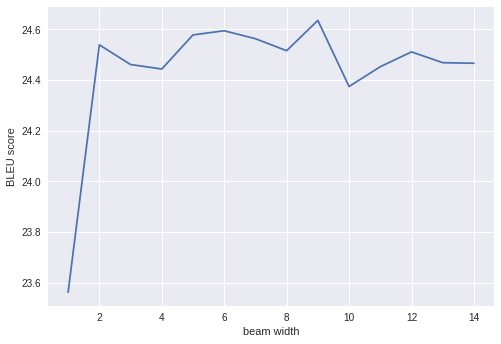

In [10]:
plt.plot(range(1,15),[score['greedy_score']]+score['beam_score'])
plt.xlabel('beam width')
plt.ylabel('BLEU score')

# Plot training loss for GRU/LSTM to compare speed

In [0]:
score1 = torch.load(
           "/content/drive/My Drive/saved_scores/LSTM_attnIsTrue_hiddenSize512_nLayer2_batchSize64_epoch20_srcVocSize19000_tgtVocSize22000_lrDecayFalse_teacherF1")

In [0]:
score2 = torch.load(
           "/content/drive/My Drive/saved_scores/attnIsTrue_hiddenSize512_nLayer2_batchSize64_epoch20_srcVocSize20000_tgtVocSize32000_lrDecayFalse_teacherF1")

In [0]:
# This is the loss of each epoch from self-attention
score3 = [4.545370580658081,
 3.537611612251827,
 3.0360496749953616,
 2.672862425115373,
 2.394343628107555,
 2.1719146188289393,
 1.9884819965513922,
 1.8350102686692797,
 1.707337155985454,
 1.5958151286556606,
 1.4975455459148164,
 1.4124447373170703,
 1.3285594105247467,
 1.2610603803207003,
 1.1966657795603315]

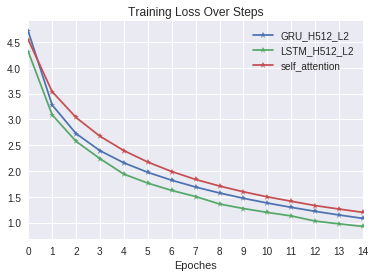

In [56]:
CHAR_GRU_H512_L4 = score1['plot_losses']
CHAR_LSTM_H512_L4 = score2['plot_losses']

def average_loss(losses):
    average_losses = []
    for i in range(0,320,20):
        average_losses.append(np.mean(losses[i:i+20]))
    return average_losses

fig, ax = plt.subplots(figsize=(6, 4))
# this locator puts ticks at regular intervals
loc = ticker.MultipleLocator(base=1)
ax.xaxis.set_major_locator(loc)
ax.set_xlim(xmin = 0,xmax = 14)
plt.plot(average_loss(score1['plot_losses']), marker = '*',label = 'GRU_H512_L2')
plt.plot(average_loss(score2['plot_losses']), marker = '*',label = 'LSTM_H512_L2')
plt.plot(score3, marker='*', label='self_attention')

plt.xlabel("Epoches")

plt.title("Training Loss Over Steps")
plt.legend()

# Evaluate on test set

In [55]:
hidden_size = 1024
n_layers = 2
teacher_forcing_ratio = 1
n_iters = 20
source_vocab_size = 19000
target_vocab_size = 22000
beam_size = 7

encoder_current = EncoderRNN(input_lang.n_words, hidden_size,n_layers=n_layers).to(device)
decoder_current = LuongAttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, dropout=dropout_p, n_layers=n_layers).to(device)
checkpoint = torch.load("/content/drive/My Drive/saved_model/LSTM_attnIs{}_hiddenSize{}_nLayer{}_batchSize{}_epoch{}_srcVocSize{}_tgtVocSize{}_lrDecay{}_teacherF{}"\
                    .format(Attention,hidden_size,n_layers,BATCH_SIZE,n_iters,source_vocab_size, target_vocab_size,lr_decay,teacher_forcing_ratio))
encoder_current.load_state_dict(checkpoint['encoder'])
decoder_current.load_state_dict(checkpoint['decoder'])
encoder_current.eval()
decoder_current.eval()

test_score_beam, predicted_sentence = test_model(encoder_current, decoder_current, test_loader, search_method='beam')

print ('test score', test_score_beam)


test score 21.309190297919464
